# Forsterite Stagnation - release curve

Erik Davies - 07/06/2020

This script loads in an eos and calculates a decompression isentrope from a given shock
state until intersection with the l-v dome.

The purpose is to calculate the effect on Temperature emission the L-V mixture ahead of the phase 
boundary has. The rough idea here is to calculate the density gradient over position ~10 ns after 
the breakout. 

This should be done specifically for one impact entropy, then generally to get general behavior
of the dome depression.



Order of operations
1. Load in ANEOS isentrope
2. 
3. 

In [1]:
#User parameter inputs
#Simple user inputs, nothing else should need changing
#Enotropy value of the release isentrope
S_cho=5500 #J/K/kg

#Assume spherical expansion for volume
#Input initial compressed radius
ri=0.4 / 1000 / 1000 #km, given in mm, to km...
tp=5 #Pa,

#Set up array size for later on vapor fraction calculation
size=100000


In [2]:
#Check and record versions
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy
import pandas
print('pandas version: ', pandas.__version__)
del pandas

python version:  3.6.4
matplotlib version:  2.2.0rc1
numpy version:  1.18.1
scipy version:  1.4.1
pandas version:  1.0.1


In [3]:
# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import scipy as sp
import statistics as stat
from matplotlib import rc
import eostable as eos
#

In [4]:

########Plot Parameters begin############3
#These control font size in plots.
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':10}
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update(params)
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['axes.linewidth']= 1

plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.dashed_pattern'] = [6, 6]
plt.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
plt.rcParams['lines.dotted_pattern'] = [1, 3]
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='Times New Roman'
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams["patch.force_edgecolor"] = True

########Plot Parameters finish############3


In [5]:
#Load in model

MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# read EOS table      
forstEOS = eos.extGADtable()
forstEOS.readStdGadget('NEW-GADGET-STD-NOTENSION.TXT') # reads P-V-T-S-U-cs
forsthug = eos.EOShugoniot()
forsthug.T=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[0]) # K
forsthug.rho=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[1]) * 1000 # To kg/m^3
forsthug.P=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[2]) # Gpa
forsthug.U=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[3]) # MJ/kg
forsthug.S=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[4]) *(10**6) # J/K/kg
forsthug.up=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[5]) #km/s
forsthug.us=np.loadtxt('NEW-SESAME-HUG.TXT',delimiter=',',skiprows=3,usecols=[6]) #km/s



#Units are in CGS so replace with SI
#S is in erg/K/g
forstEOS.S=forstEOS.S *(10**(-4)) #J/K/kg
# rho is g/cm^3
forstEOS.rho=forstEOS.rho *(10**(3)) #kg/m^3
#P is dynes/cm2
forstEOS.P=forstEOS.P *(10**(-10))#GPa
#T is K, do nothing
#Cs, sound sped is cm/s
forstEOS.cs=forstEOS.cs *(10**(-5)) 

In [6]:
#More model stuff - taken from forsterite_aneos.ipynb
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#
# generate output files for other ANEOS models
modelflag = 0   # 0 - don't change anything above; 1 - Canup et al. 2013; 
                # 2 - GADGET2 Marcus PhD Thesis & Cuk & Stewart 2012; 3 - ISALE Dellen Collins and Melosh 2014
#

# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = eos.extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')

Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 * Reference solid Hugoniot at STP initial density and temperature
 ANEOS1    -1        'Forsterite STS SLVTv1.0'     THUG=0.02568    RHUG=3.22     LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    3         4         3.22      298.      1.e6      1.10E12   0.65      -1300.

 *         TG model  Gamma     Esep      Tmelt(K)  ..Critical Pt..     Thermal Conduction
 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 ANEOS3    -1        7.5       1.70E11   2163. 

Now that everything is loaded in, the calculation begins with finding entropy indices that match the user input, and finding the relevant shock state.

In [7]:
#Find shock state, and eos index for given entropy
#First entropy index
Si_min=min(min(np.where(S_cho<forstEOS.S)))
Si_max=max(min(np.where(S_cho>forstEOS.S)))
temp1=abs(forstEOS.S[Si_min]-S_cho)
temp2=abs(forstEOS.S[Si_max]-S_cho)
S_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    S_ind=Si_max

#Same as above except for hugoniot index
Si_min=min(min(np.where(S_cho<forsthug.S)))
Si_max=max(min(np.where(S_cho>forsthug.S)))
temp1=abs(forsthug.S[Si_min]-S_cho)
temp2=abs(forsthug.S[Si_max]-S_cho)
Sh_ind=Si_min #Set index to first one
if temp1 > temp2: #if temp2 is smaller use that one instead
    Sh_ind=Si_max

#Similar to above, finding peak pressure index of eos # i may not need this one.
Pi_max=max(min(np.where(forsthug.P[Sh_ind]>forstEOS.P[S_ind,:])))
P_ind=Pi_max #Set index to first one

#Also find L-V intersection of isentrope

if S_cho < NewEOS.cp.S*(10**6):
    print('got to s_cho less than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sl*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sl*(10**6))))
    temp1=abs(NewEOS.vc.Sl[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sl[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=0 #Set a flag for later
        
if S_cho > NewEOS.cp.S*(10**6):
    print('got to s_cho more than CP')
    Si_min=min(min(np.where(S_cho>NewEOS.vc.Sv*(10**6))))
    Si_max=max(min(np.where(S_cho<NewEOS.vc.Sv*(10**6))))
    temp1=abs(NewEOS.vc.Sv[Si_min]*(10**6)-S_cho)
    temp2=abs(NewEOS.vc.Sv[Si_max]*(10**6)-S_cho)
    Slv_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Slv_ind=Si_max
        lvFlag=1 #Set flag for later


#Print the Shock state
print('The Shock State for chosen entropy = ',S_cho,' J/K/kg')
print('Peak Pressure = ',forsthug.P[Sh_ind], ' GPa')
print('Peak Temperature = ',forsthug.T[Sh_ind], ' K')
print('Peak Density = ',forsthug.rho[Sh_ind], ' Kg/m^3')
print('Peak Shock Velocity = ',forsthug.us[Sh_ind], ' km/s')
print('Peak Particle Velocity = ',forsthug.up[Sh_ind], ' km/s')

#print(forstEOS.P[S_ind,P_ind])

got to s_cho less than CP
The Shock State for chosen entropy =  5500  J/K/kg
Peak Pressure =  465.5994  GPa
Peak Temperature =  15292.44  K
Peak Density =  6678.0  Kg/m^3
Peak Shock Velocity =  16.71048  km/s
Peak Particle Velocity =  8.653015  km/s


The next cell calculates the expansion velocity of the isentrope. It uses a Riemann integral to translate volume changes with respect to pressure changes to calculate the change in particle velocity.


In [8]:
 ###################
#Given an initial radius sphere, how long does it take to expand to the "Final" radius?
#Take the triple point as the final pressure
Pi_max=max(min(np.where(tp*(10**(-9))>forstEOS.P[S_ind,:])))
Ptp_ind=Pi_max #Index of triple point

#Volume ratio is the density at the shocked pressure over the released TP pressure
VR=forstEOS.rho[P_ind]/forstEOS.rho[Ptp_ind]
#So final radius (assuming sphere v = 4/3 pi r^3)     vf/vi = rf^3/ri^3 so rf = ri * (vf/vi)^(1/3)
rf=ri*(VR) #km

#The way this calc works, is that the parcel is allowed to keep expanding until the final radius is met
# until the final radius is met, the parcel is inertially trapped integrate for time to volume at each
# density index so we get a cool time profile
#We use the above lines to scale the volume increase for each step. 
rf_scaled = np.zeros(P_ind-Ptp_ind)
time_dt= np.zeros(P_ind-Ptp_ind)
total_time= np.zeros(P_ind-Ptp_ind)
up_exp = np.zeros(P_ind-Ptp_ind)
up_del = np.zeros(P_ind-Ptp_ind)
rho_part= np.zeros(P_ind-Ptp_ind)
up_part= np.zeros(P_ind-Ptp_ind)

#Fill in radius array
for i in range(P_ind-Ptp_ind):
    VR_scaled=forstEOS.rho[P_ind]/forstEOS.rho[P_ind-i]
    rf_scaled[i]=ri*(VR_scaled)
    rf_mscaled=rf_scaled*1000
#Calculate time to get to each step
for i in range(P_ind-Ptp_ind):
    if i == 0:
        up_exp[0] = forsthug.up[Sh_ind]#*1000 
        up_del[0] = forsthug.up[Sh_ind]
        time_dt[0] = (rf_scaled[i]-ri)/up_exp[0]
    if i > 0:
        rho_part[i]=((forstEOS.cs[S_ind,P_ind-i+1]*1000 /forstEOS.rho[P_ind-i+1])* 
                                   (forstEOS.rho[P_ind-i]-forstEOS.rho[P_ind-i+1]))
        up_part[i]=(2*(-1000*up_del[i-1])/rf_mscaled[i-1])*(rf_mscaled[i]-rf_mscaled[i-1])
        
        up_del[i] = up_del[i-1] - (rho_part[i] - 0*up_part[i])/1000 # this value actually gets weird sometimes.
        
        if up_del[i] < up_del[i-1]:
            up_del[i] = up_del[i-1]
        
        up_exp[i] = up_del[i] #- up_del[i]/1000
        time_dt[i] = (rf_scaled[i]-rf_scaled[i-1])/up_exp[i]
#Calc integrated time now

total_time[0] = time_dt[0]
for i in range(1,np.size(time_dt)):
    total_time[i] = total_time[i-1] + time_dt[i]

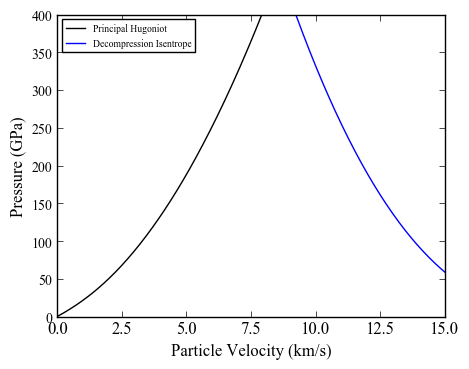

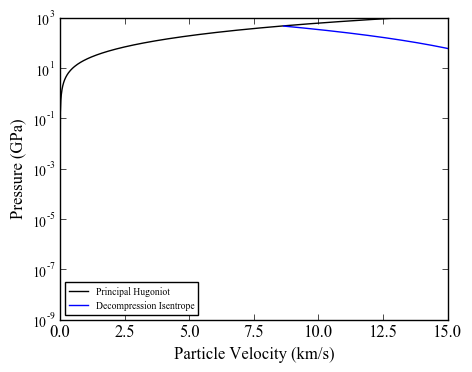

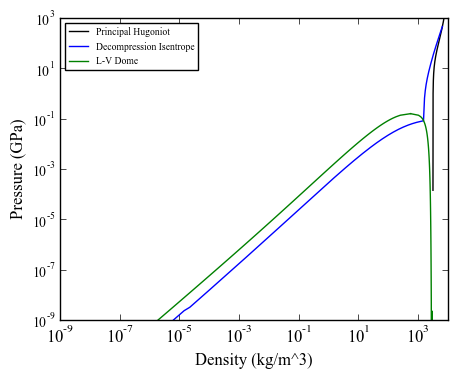

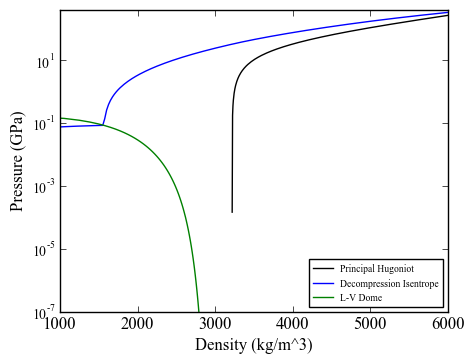

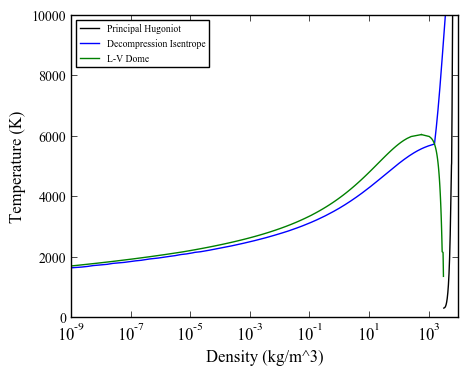

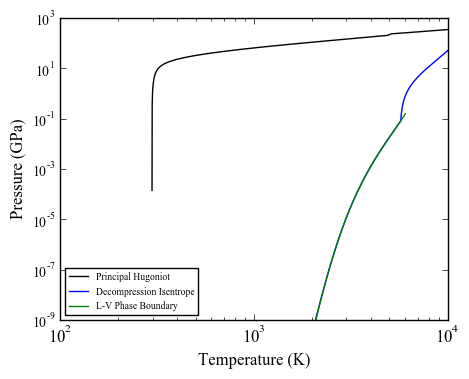

In [9]:
####EOS PLOTTING###
##P-UP###
plt.figure()
plt.plot(forsthug.up,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(up_exp[::-1],forstEOS.P[S_ind,Ptp_ind:P_ind],'-',color='blue',label='Decompression Isentrope')

#plt.semilogy()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Particle Velocity (km/s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(0,15)
plt.ylim(0,400)
plt.savefig('P_Up_ExpansionVelocity.pdf', format='pdf', dpi=1000)

##P-UP###
plt.figure()
plt.plot(forsthug.up,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(up_exp[::-1],forstEOS.P[S_ind,Ptp_ind:P_ind],'-',color='blue',label='Decompression Isentrope')

plt.semilogy()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Particle Velocity (km/s)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(0,15)
plt.ylim(10**(-9),1000)
plt.savefig('P_Up_ExpansionVelocity_log.pdf', format='pdf', dpi=1000)

##P-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)


#plt.xlim(0,20)
plt.ylim(10**(-9),1000)
plt.xlim(10**(-9),10000)
plt.savefig('P_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.Pl,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.Pv,'-',color='green')

plt.semilogy()
#plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(10**(-7),400)
plt.xlim(1000,6000)
plt.savefig('P_Rho_decompression_lin.pdf', format='pdf', dpi=1000)

##/t-rho###
plt.figure()
plt.plot(forsthug.rho,forsthug.T,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.rho[:P_ind+1],forstEOS.T[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.rl*1000,NewEOS.vc.T,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.rv*1000,NewEOS.vc.T,'-',color='green')

#plt.semilogy()
plt.semilogx()


plt.ylabel('Temperature (K)')
plt.xlabel('Density (kg/m^3)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlim(10**(-9),10000)
plt.savefig('T_Rho_decompression.pdf', format='pdf', dpi=1000)

##P-T###
plt.figure()
plt.plot(forsthug.T,forsthug.P,'-',color='black',label='Principal Hugoniot')
plt.plot(forstEOS.T[S_ind,:P_ind+1],forstEOS.P[S_ind,:P_ind+1],'-',color='blue',label='Decompression Isentrope')
plt.plot(NewEOS.vc.T,NewEOS.vc.Pv,'-',color='green',label='L-V Phase Boundary')

#NewEOS.vc.T

plt.semilogy()
plt.semilogx()

plt.ylabel('Pressure (GPa)')
plt.xlabel('Temperature (K)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

plt.xlim(100,10000)
plt.ylim(10**(-9),1000)
plt.savefig('T_P_decompression.pdf', format='pdf', dpi=1000)


plt.show()

With EOS and expansions velocity profile, what does the density gradient look like over time. Method of characteristics from the Zel'dovich, done again in Kraus 2012. Essentially calculate density fan starting from a single langrangian point. First Calculate slopes, then transform the results into a density gradient at specific times.

$(dh/dt)_i = \rho_i c_{s,i}/\rho_0$

Slope of characteristc equation in lagrangian coordinates. I have sound speeds indexed by density and entropy. So for a specific index of rho and S, I would have a sound speed. This of course only works easily on an isentrope.

I already have the starting shock density, and entropy. Entropy is constant, so make an interpolator for density and soundspeed at the shock entropy. Then I can take density steps for the characteristic equation.

I should then be able to generalize this a bit and do it at many entropies to get a density gradient function at a certain time for all entropies.

Sound speed is giving me issues, so derive it instead. 
$c = \sqrt{\frac{\delta p}{\delta \rho}}$ at constant entropy.

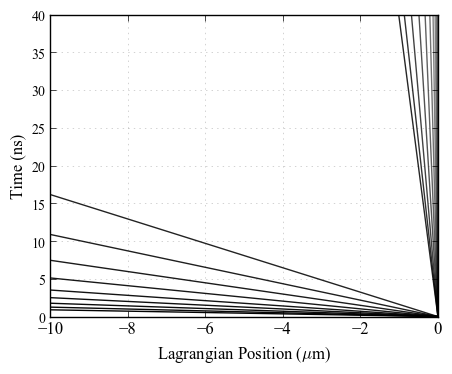

In [72]:
#print(np.shape(forstEOS.cs))
#print(np.shape(forstEOS.rho))
#print(np.shape(forstEOS.S))
#print(np.shape(forsthug.S))
#print(np.shape(forsthug.rho))
#Set up interpolators for entropy in the vapor dome based on pressure
#Cs_rho=interpolate.interp1d(forstEOS.rho[:],(forstEOS.cs[S_ind,:])) #sound speed from rho
#Sound speed in this eos jumps to some bottomed out zero. 

#Calc c from the above now...
Cs_temp = np.zeros(np.size(forstEOS.rho))

for i in range(np.size(forstEOS.rho)-1):
    Cs_temp[i+1] = ((10**9)*(forstEOS.P[S_ind,i+1] - forstEOS.P[S_ind,i])/(forstEOS.rho[i+1]-forstEOS.rho[i]))**(1/2)
    #Cs_temp[i+1] = Cs_temp[i+1] / 1000
    
Cs_rho=interpolate.interp1d(forstEOS.rho[:],( Cs_temp[:])) #sound speed from rho


rho_S=interpolate.interp1d(forsthug.S,forsthug.rho) #Shock rho from entropy
#print(rho_S(S_cho))
#print(Cs_rho(rho_S(S_cho)))
#Now set up The loop for the characteristic equation
#I want to do 0.1 or so density jumps so set up arrays of that size...
Densityjump=0.97 #percentage jump, for more density points at lower density
Count_int = 325#int(rho_S(S_cho)/Densityjump) #grabbing the size.
#print(Count_int)

L_slopes =  np.zeros(Count_int)
lag_pos = np.linspace(-1000*10**(-6),0,100)
time_ar = np.zeros((Count_int, np.size(lag_pos)))
C_dens =  np.zeros(Count_int) #characterstic density thing

for i in range(Count_int):
    #C_dens [i] = (rho_S(S_cho) - (i * Densityjump))
    C_dens [i] = (rho_S(S_cho) * (Densityjump**i))
    L_slopes[i] = C_dens[i]* Cs_rho(C_dens[i])/(rho_S(S_cho)) #
    #L_slopes is organized from shock density to decompressed at higher indices.
    time_ar[i,:] = lag_pos *(-1/L_slopes[i])
    
    
plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)

for i in range(65,Count_int,20):
    plt.plot(lag_pos*10**6, time_ar[i,:]*10**9, color="black",alpha =(1 -((i - 1)/Count_int)) )
for i in range(0,55,5):
    plt.plot(lag_pos*10**6, time_ar[i,:]*10**9, color="black",alpha =(1 -((i - 1)/Count_int)) )

plt.xlabel('Lagrangian Position ($\mu$m)')
plt.ylabel('Time (ns)')
plt.xlim(-10,0)
plt.ylim(0,40)
#plt.legend(loc='upper right', fontsize='x-small',numpoints=1,scatterpoints=1 )
plt.grid()
plt.savefig('LagrangianP_densityFan.pdf', format='pdf', dpi=1000)

In [68]:
#C_dens


Now that I have a density fan, I can integrate to get eulerian position. Also from Kraus et al. 2012,

$\int_{x_0}^{x(\rho_i)} dx = \int_{0}^{h(\rho_i)} \frac{\rho_0}{\rho} dh$.

To evaluate this integral, I need to determine the dependence of $\rho$ on h. This is really only possible to evaluate at a single time. 

$(dh/dt)_i = \rho_i c_{s,i}/\rho_0$ integrating this gives

$h(\rho_i) = \frac{\rho_i c_{s,i}}{\rho_0} t$

evaluated for each side from 0 to $t$ or $h$. For specific times, $h$ has a dependence on $\rho$.

In [73]:
#set up h array, for three times
h_temp5 = np.zeros(Count_int)
h_temp10 = np.zeros(Count_int)
h_temp15 = np.zeros(Count_int)

x5 = np.zeros(Count_int)
x10 = np.zeros(Count_int)
x15 = np.zeros(Count_int)

time5 = 5*10**(-9)
time10 = 10*10**(-9)
time15 = 15*10**(-9)


h_temp5 = (time5)*C_dens[:]* (-1)*Cs_rho(C_dens[:])/(rho_S(S_cho))
h_temp10 = (time10)*C_dens[:]*(-1)* Cs_rho(C_dens[:])/(rho_S(S_cho))
h_temp15 = (time15)*C_dens[:]* (-1)*Cs_rho(C_dens[:])/(rho_S(S_cho))

#interpolate to get dependence of rho on h.
rho_h5 = interpolate.interp1d(h_temp5,rho_S(S_cho)/C_dens[:],fill_value="extrapolate") #rho from h5
rho_h10 = interpolate.interp1d(h_temp10,rho_S(S_cho)/C_dens[:],fill_value="extrapolate") #rho from h5
rho_h15 = interpolate.interp1d(h_temp15,rho_S(S_cho)/C_dens[:],fill_value="extrapolate") #rho from h5

for i in range(Count_int):
    x5[i] = integrate.quad(rho_h5,0,h_temp5[i])[0]
    x10[i] = integrate.quad(rho_h10,0,h_temp10[i])[0]
    x15[i] = integrate.quad(rho_h15,0,h_temp15[i])[0]





c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the i

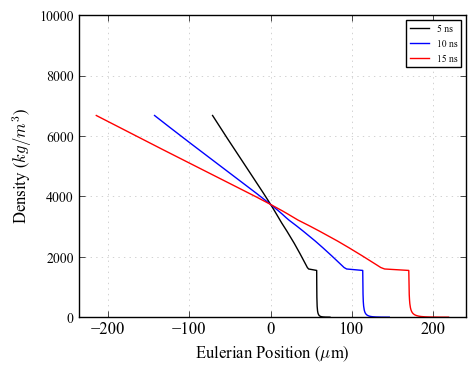

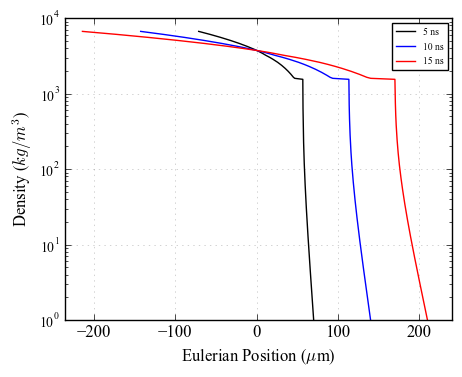

In [108]:
 #integrate.quad(rho_s,forsthug.P[Sh_ind]*(10**9),forstEOS.P[S_ind,P_ind-i]*(10**9))[0]
plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)

plt.plot(x5*10**6+(Cs_rho(C_dens[0]) * time5 *10**6), C_dens[:], color="black",label ='5 ns')
plt.plot(x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6), C_dens[:], color="blue",label ='10 ns')
plt.plot(x15*10**6+(Cs_rho(C_dens[0]) * time15*10**6), C_dens[:], color="Red",label ='15 ns')
                                  

plt.xlabel('Eulerian Position ($\mu$m)')
plt.ylabel('Density ($kg/m^3$)')
#plt.xlim(0,500)
plt.ylim(1,10**4)
#plt.semilogy()
plt.legend(loc='upper right', fontsize='x-small',numpoints=1,scatterpoints=1 )
plt.grid()
plt.savefig('Eulerian_DensProfile_lin.pdf', format='pdf', dpi=1000)

plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)

plt.plot(x5*10**6+(Cs_rho(C_dens[0]) * time5 *10**6), C_dens[:], color="black",label ='5 ns')
plt.plot(x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6), C_dens[:], color="blue",label ='10 ns')
plt.plot(x15*10**6+(Cs_rho(C_dens[0]) * time15*10**6), C_dens[:], color="Red",label ='15 ns')
                                  

plt.xlabel('Eulerian Position ($\mu$m)')
plt.ylabel('Density ($kg/m^3$)')
#plt.xlim(0,500)
plt.ylim(1,10**4)
plt.semilogy()
plt.legend(loc='upper right', fontsize='x-small',numpoints=1,scatterpoints=1 )
plt.grid()
plt.savefig('Eulerian_DensProfile.pdf', format='pdf', dpi=1000)

It is noted that the eulerian position is referenced to experiment position here. The decompression wave is propagating back through the sample, such that momentum is conserved.

Now that I have a density gradient in front of the density plateau, I can integrate through a mean free path calculation to obtain a optical depth of the temperature to determine the temperature of the observed liquid wall. 

Before generalizing for the entire dome at 10 ns or so, which would be consistent for measured areas of vapor plume measurements...

The essential part of this calculation is the mean free path calculation, which is dominate here because of the assumption that vapor absorption is negligible.

So mean free path is 

$MFP = (4/6)*(condensate size)*\frac{density of liquid}{density of bulk} = (4/6) D  \frac{\rho_{liq}}{\rho_{bulk}}$

and the optical depth is dependent on the probability of a photon be emitted when the probability equals 1. 

so 

$Pr(x) = \alpha(x)dx = \frac{dx}{L_{MFP}(x)} + \alpha_{vap}(x)dx$

and as mentioned, I am neglecting the vapor term, and the optical depth is the integration  at unity...

$\int^{x(T_a)}_{x_{fs}} \alpha(x)dx = 1$

so plugging in.,

$\int^{x(T_a)}_{x_{fs}} \frac{dx}{L_{MFP}(x)} = 1$

$\int^{x(T_a)}_{x_{fs}} \frac{dx}{(4/6) D  \frac{\rho_{liq}(x)}{\rho_{bulk}(x)}} = 1$

The densities are dependent on pressure which is mapped to the eulerian position.

So I will make interpolations of liquid dome densities, and isentrope densities for a speciic entropy and integrate that.

I will only be integrating from below the liquid wall density.

In [167]:
#for the specific case, I need the density of liquid on the boundary mapped to pressure
#Make an interpolator for L-V liquid side density
rho_p_lv=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rl*1000))

#And P as a function of rho on an isentrope is 
rho_p_isen=interpolate.interp1d(forstEOS.rho,forstEOS.P[S_ind,:]*(10**9)) #in Pa

#And T as a function of rho on an isentrope is 
rho_T_isen=interpolate.interp1d(forstEOS.rho,forstEOS.T[S_ind,:]) #in K

#This function will give liquid density.
# we already have entropy as well, so do grab a interpolation of the entropy with pressure
rho_s_lv=interpolate.interp1d(NewEOS.vc.Sl*(10**6),(NewEOS.vc.rl*1000))

#also grab an interpolation of rho from position. Cs_rho(C_dens[0])
rho_pos = interpolate.interp1d(x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6),C_dens) #takes microns
pos_rho = interpolate.interp1d(C_dens,x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6))#Gives microns

#So the entire density array under the dome is represented by 
dens_temp = min(np.where(C_dens < rho_s_lv(S_cho)))
#print(dens_temp,C_dens[dens_temp],rho_s_lv(S_cho))
Isen_dens_underDome = C_dens[dens_temp]
Isen_P_underDome = rho_p_isen(C_dens[dens_temp])
isen_pos = pos_rho(Isen_dens_underDome) * 10**(-6)
#And I should now have all of the densities...

#Set up D's for seperate MFP calcs
d100=10**(-7) #meters
d500=5*10**(-7) #meters
d1000=10**(-6) #meters

MFP100 = (4/6) * d100 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)
MFP500 = (4/6) * d500 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)
MFP1000 = (4/6) * d1000 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)

#now three interpolations based on MFP and position, both indexed to isentrope density array
int100 = interpolate.interp1d(isen_pos,1/MFP100)
int500 = interpolate.interp1d(isen_pos,1/MFP500)
int1000 = interpolate.interp1d(isen_pos,1/MFP1000)

#Now while integrate each position step until unity

count = np.size(isen_pos)
i=0
check = 100
while abs(check - 1) >0.05: 
    i = i + 1
    unity100 = integrate.quad(int100,isen_pos[-1],isen_pos[count-1 - i])[0]
    check = abs(unity100)
    #print(check)
    if i > np.size(isen_pos):
        print('the while loop integrator broke')
        break  
    if check > 1.05:
        print('unity exceeded')
        break
#print(i)
#print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
i100 = i

i=0
check = 100
while abs(check - 1) >0.05: 
    i = i + 1
    unity500 = integrate.quad(int500,isen_pos[-1],isen_pos[count-1 - i])[0]
    check = abs(unity500)
    #print(check)
    if i > np.size(isen_pos):
        print('the while loop integrator broke')
        break   
    if check > 1.05:
        print('unity exceeded')
        break
#print(i)
#print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
i500 = i

i=0
check = 100
while abs(check - 1) >0.05: 
    i = i + 1
    unity1000 = integrate.quad(int1000,isen_pos[-1],isen_pos[count-1 - i])[0]
    check = abs(unity1000)
    #print(check)
    if i > np.size(isen_pos):
        print('the while loop integrator broke')
        break    
    if check > 1.05:
        print('unity exceeded')
        break
#print(i)
#print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
i1000 = i



T100 = rho_T_isen(Isen_dens_underDome[count-1 -i100])
T500 = rho_T_isen(Isen_dens_underDome[count-1 -i500])
T1000 = rho_T_isen(Isen_dens_underDome[count-1 -i1000])

print(T100,T500,T1000)
print('liquid wall T',rho_T_isen(rho_s_lv(S_cho)))    
#Now that we have index that gets us close to within 5 percent of unity


c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:65: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
 

4669.240065807114 5309.613275686088 5595.014514569917
liquid wall T 5767.161918497713


In [169]:
MFP100
int100,isen_pos[-1]
rho_s_lv=interpolate.interp1d(NewEOS.vc.Sl*(10**6),(NewEOS.vc.T))

Now I want to create an entire dome that calculates temperature of the optical depth density for 10 ns after breakout apparant temperature.

So I want to calculate a density gradient for many given entropies...

I am using a big loop to set an entropy, find the index, the isentrope, and calculate the characteristic lines. Then integrate into eulerian and finally integrate the gradient into an optical path for unity and temperature.

In [195]:
#Begin a big loop of about 20 steps over the dome, choose a starting entropy
# and an end, and the script will choose consistent steps.
ent_steps = 20
begin_S = 4000
end_S = 7500

S_steps = np.linspace(begin_S,end_S,ent_steps)
T100 = np.zeros(ent_steps)
T500 = np.zeros(ent_steps)
T1000 = np.zeros(ent_steps)  

#For placing T in entropy


for j in range(ent_steps):
    
#Find shock state, and eos index for given entropy
#First entropy index
    Si_min=min(min(np.where(S_steps[j]<forstEOS.S)))
    Si_max=max(min(np.where(S_steps[j]>forstEOS.S)))
    temp1=abs(forstEOS.S[Si_min]-S_steps[j])
    temp2=abs(forstEOS.S[Si_max]-S_steps[j])
    S_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        S_ind=Si_max

    #Same as above except for hugoniot index
    Si_min=min(min(np.where(S_steps[j]<forsthug.S)))
    Si_max=max(min(np.where(S_steps[j]>forsthug.S)))
    temp1=abs(forsthug.S[Si_min]-S_steps[j])
    temp2=abs(forsthug.S[Si_max]-S_steps[j])
    Sh_ind=Si_min #Set index to first one
    if temp1 > temp2: #if temp2 is smaller use that one instead
        Sh_ind=Si_max

    #With the indices found calculate lagrangian characteristic lines########
    #grab sound speed
    Cs_temp = np.zeros(np.size(forstEOS.rho))

    for i in range(np.size(forstEOS.rho)-1):
        Cs_temp[i+1] = ((10**9)*(forstEOS.P[S_ind,i+1] - forstEOS.P[S_ind,i])/(forstEOS.rho[i+1]-forstEOS.rho[i]))**(1/2)
        #Cs_temp[i+1] = Cs_temp[i+1] / 1000
    
    Cs_rho=interpolate.interp1d(forstEOS.rho[:],( Cs_temp[:])) #sound speed from rho


    rho_S=interpolate.interp1d(forsthug.S,forsthug.rho) #Shock rho from entropy
    #
    
    Densityjump=0.97 #percentage jump, for more density points at lower density
    Count_int = 325#int(rho_S(S_cho)/Densityjump) #grabbing the size.
    #print(Count_int)

   # L_slopes =  np.zeros(Count_int)
    #lag_pos = np.linspace(-1000*10**(-6),0,100)
    #time_ar = np.zeros((Count_int, np.size(lag_pos)))
    C_dens =  np.zeros(Count_int) #characterstic density thing

    for i in range(Count_int):
        #C_dens [i] = (rho_S(S_cho) - (i * Densityjump))
        C_dens [i] = (rho_S(S_cho) * (Densityjump**i))
        #L_slopes[i] = C_dens[i]* Cs_rho(C_dens[i])/(rho_S(S_cho)) #not needed here
        #L_slopes is organized from shock density to decompressed at higher indices.
        #time_ar[i,:] = lag_pos *(-1/L_slopes[i]) #dont need time arrays
    
    #####################################
    #Now that I have characteristic eqs, do integration for 10 ns
    
    #set up h array, for three times

    h_temp10 = np.zeros(Count_int)

    x10 = np.zeros(Count_int)

    time10 = 10*10**(-9)

    h_temp10 = (time10)*C_dens[:]*(-1)* Cs_rho(C_dens[:])/(rho_S(S_cho))

    #interpolate to get dependence of rho on h.
    rho_h10 = interpolate.interp1d(h_temp10,rho_S(S_cho)/C_dens[:],fill_value="extrapolate") #rho from h5

    for i in range(Count_int):
        x10[i] = integrate.quad(rho_h10,0,h_temp10[i])[0]
    #####Now integrate for optical depth of the density gradient#####

     #for the specific case, I need the density of liquid on the boundary mapped to pressure
    #Make an interpolator for L-V liquid side density
    rho_p_lv=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rl*1000),fill_value="extrapolate")#

    #And P as a function of rho on an isentrope is 
    rho_p_isen=interpolate.interp1d(forstEOS.rho,forstEOS.P[S_ind,:]*(10**9)) #in Pa

    #And T as a function of rho on an isentrope is 
    rho_T_isen=interpolate.interp1d(forstEOS.rho,forstEOS.T[S_ind,:]) #in K

    #This function will give liquid density.
    # we already have entropy as well, so do grab a interpolation of the entropy with pressure
    rho_s_lv=interpolate.interp1d(NewEOS.vc.Sl*(10**6),(NewEOS.vc.rl*1000))

    #also grab an interpolation of rho from position. Cs_rho(C_dens[0])
    rho_pos = interpolate.interp1d(x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6),C_dens) #takes microns
    pos_rho = interpolate.interp1d(C_dens,x10*10**6+(Cs_rho(C_dens[0]) * time10*10**6))#Gives microns

    #So the entire density array under the dome is represented by 
    dens_temp = min(np.where(C_dens < rho_s_lv(S_cho)))
    #print(dens_temp,C_dens[dens_temp],rho_s_lv(S_cho))
    Isen_dens_underDome = C_dens[dens_temp]
    Isen_P_underDome = rho_p_isen(C_dens[dens_temp])
    isen_pos = pos_rho(Isen_dens_underDome) * 10**(-6)
    #And I should now have all of the densities...
   
    #Set up D's for seperate MFP calcs
    d100=10**(-7) #meters
    d500=5*10**(-7) #meters
    d1000=10**(-6) #meters

    MFP100 = (4/6) * d100 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)
    MFP500 = (4/6) * d500 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)
    MFP1000 = (4/6) * d1000 * (rho_p_lv(Isen_P_underDome)/Isen_dens_underDome)

    #now three interpolations based on MFP and position, both indexed to isentrope density array
    int100 = interpolate.interp1d(isen_pos,1/MFP100)
    int500 = interpolate.interp1d(isen_pos,1/MFP500)
    int1000 = interpolate.interp1d(isen_pos,1/MFP1000)

    #Now while integrate each position step until unity    
    count = np.size(isen_pos)
    i=0
    check = 100
    breakcheck1 = 0
    while abs(check - 1) >0.05: 
        i = i + 1
        unity100 = integrate.quad(int100,isen_pos[-1],isen_pos[count-1 - i])[0]
        check = abs(unity100)
        #print(check)
        if i > np.size(isen_pos):
            print('the while loop integrator broke, or optically thin')
            breakcheck1=1
            #T100[j] = rho_T_isen(Isen_dens_underDome[0])
            break  
        if check > 1.05:
            print('unity exceeded')
            break
    #print(i)
    #print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
    i100 = i

    i=0
    check = 100
    breakcheck2 = 0
    while abs(check - 1) >0.05: 
        i = i + 1
        unity500 = integrate.quad(int500,isen_pos[-1],isen_pos[count-1 - i])[0]
        check = abs(unity500)
        #print(check)
        if i > np.size(isen_pos):
            print('the while loop integrator broke, or optically thin')
            breakcheck2 = 1
            #T500[j] = rho_T_isen(Isen_dens_underDome[0])
            break   
        if check > 1.05:
            print('unity exceeded')
            break
    #print(i)
    #print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
    i500 = i

    i=0
    check = 100
    breakcheck3 = 0
    while abs(check - 1) >0.05: 
        i = i + 1
        unity1000 = integrate.quad(int1000,isen_pos[-1],isen_pos[count-1 - i])[0]
        check = abs(unity1000)
        #print(check)
        if i > np.size(isen_pos):
            print('the while loop integrator broke, or optically thin')
            breakcheck3 = 1
            #T1000[j] = rho_T_isen(Isen_dens_underDome[0])
            break    
        if check > 1.05:
            print('unity exceeded')
            break
    #print(i)
    #print(isen_pos[count-1 - i],isen_pos[-1] -isen_pos[count-1 - i]  )
    i1000 = i


    T100[j] = rho_T_isen(Isen_dens_underDome[count-1 -i100])
    if breakcheck1 == 1:
        T100[j] = rho_T_isen(Isen_dens_underDome[0])
    
    T500[j] = rho_T_isen(Isen_dens_underDome[count-1 -i500])
    if breakcheck2 == 1:
        T500[j] = rho_T_isen(Isen_dens_underDome[0])
    
    T1000[j] = rho_T_isen(Isen_dens_underDome[count-1 -i1000])  
    if breakcheck3 == 1:
        T1000[j] = rho_T_isen(Isen_dens_underDome[0])
    
    #print('liquid wall T',rho_T_isen(rho_s_lv(S_cho)))   
    

c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


the while loop integrator broke, or optically thin


c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:153: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:153: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


the while loop integrator broke, or optically thin


c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:173: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:173: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin


c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:83: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:83: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin


c:\users\erikj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:83: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin
the while loop integrator broke, or optically thin


19315.336461001625


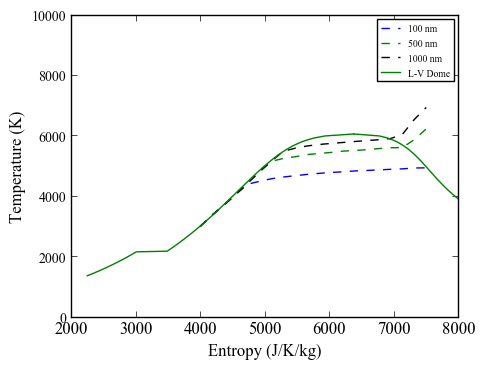

In [196]:
print(rho_T_isen(Isen_dens_underDome[0]))

plt.figure()
#plt.plot(forsthug.rho,forsthug.T,'-',color='black',label='Principal Hugoniot')
plt.plot(S_steps,T100[:],'--',color='blue',label='100 nm')
plt.plot(S_steps,T500[:],'--',color='green',label='500 nm')
plt.plot(S_steps,T1000[:],'--',color='black',label='1000 nm')
plt.plot(NewEOS.vc.Sl*(10**6),NewEOS.vc.T,'-',color='green',label='L-V Dome')
plt.plot(NewEOS.vc.Sv*(10**6),NewEOS.vc.T,'-',color='green')

#plt.semilogy()
#plt.semilogx()


plt.ylabel('Temperature (K)')
plt.xlabel('Entropy (J/K/kg)')
plt.legend(loc='best', fontsize='x-small',numpoints=1,scatterpoints=1)

#plt.xlim(0,20)
plt.ylim(0,10000)
plt.xlim(2000,8000)
plt.savefig('T_S_DepressedDome.pdf', format='pdf', dpi=1000)

In [149]:
#Calculate Mean free path of photon paths in a cloud of silicates droplets with vapor in between. See Lock et al. 2018
# for a derivation of the mean free path through a cloud of opaque droplets with non-absorbing vapor

#MFP=(4/6)*(condensate size)*(volume of bulk/volume of liquid)      or
#MFP=(4/6)*(condensate size)*(rho_l/rho_bulk) 


rho_s_lv=interpolate.interp1d(NewEOS.vc.Pl*(10**9),(NewEOS.vc.rl*1000))

#MFP depends on mean size of droplets, which we don't know, so lots of cases
#Diameter of example condensates
d1=10**(-6) #meters
d2=10**(-5) #meters
d3=10**(-4) #meters
d4=10**(-3) #meters
d5=10**(-2) #meters
d6=10**(-1) #meters



#This calculation assumes that SCF also behaves like the liquid - reflectivity measurements
#in shock experiments (where the shocked material is supercritical) seem to confirm this.
# decompression to the L-V dome is almost instantaneous as well so its probably not a huge deal

#So we have to deal with this in two steps. Using decompression pressure index, calculate MFP down to the edge
# of the dome. Volume of bulk and liquid are the same for this part, therefore the MFP is the condensate size. 
#After the intersection then MFP can grow. 

#        Slv_ind=Si_max
#        lvFlag=1 #Set flag for later
#First set up MFP arrays as 
#This could probably be done as a single array

MFP1=np.zeros(P_ind-Ptp_ind)
MFP2=np.zeros(P_ind-Ptp_ind)
MFP3=np.zeros(P_ind-Ptp_ind)
MFP4=np.zeros(P_ind-Ptp_ind)
MFP5=np.zeros(P_ind-Ptp_ind)
MFP6=np.zeros(P_ind-Ptp_ind)

if lvFlag ==0: #Liquid side of CP
    for i in range(P_ind-Ptp_ind):
        if forstEOS.P[S_ind,P_ind - i] > NewEOS.vc.Pl[Slv_ind]: #Down to the dome
            MFP1[i]=(4/6)*(d1)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
        if forstEOS.P[S_ind,P_ind - i] < NewEOS.vc.Pl[Slv_ind]: #From the dome to the TP
            MFP1[i]=(4/6)*(d1)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]   
if lvFlag ==1: # vapor side of CP
    for i in range(P_ind-Ptp_ind): 
        if forstEOS.P[S_ind,P_ind - i] > NewEOS.vc.Pv[Slv_ind]:
            MFP1[i]=(4/6)*(d1)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*forstEOS.rho[P_ind - i]/forstEOS.rho[P_ind - i]
        if forstEOS.P[S_ind,P_ind - i] < NewEOS.vc.Pv[Slv_ind]:
            MFP1[i]=(4/6)*(d1)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP2[i]=(4/6)*(d2)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP3[i]=(4/6)*(d3)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP4[i]=(4/6)*(d4)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP5[i]=(4/6)*(d5)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]
            MFP6[i]=(4/6)*(d6)*rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9))/forstEOS.rho[P_ind - i]     
    


In [ ]:
#print(NewEOS.vc.Pl)
#print(NewEOS.vc.Pv)
#print(rho_s_lv(forstEOS.P[S_ind,P_ind - i]*(10**9)))
#rho_s(forstEOS.P[S_ind,Ptp_ind:P_ind]*(10**9))
#print(MFP1)

In [ ]:
#Plot MFP stuff
#At 
plt.figure()
plt.rc('grid',color='black', linestyle=':', linewidth=0.5,alpha=0.25)
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP1[::-1],label='D$=10^{-6}$ m',color='blue')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP2[::-1],label='$10^{-5}$ m',color='cyan')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP3[::-1],label='$10^{-4}$ m',color='green')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP4[::-1],label='$10^{-3}$ m',color='yellow')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP5[::-1],label='$10^{-2}$ m',color='orange')
plt.plot(forstEOS.rho[Ptp_ind:P_ind],MFP6[::-1],label='$10^{-1}$ m',color='brown')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Mean Free Path (m)')
plt.semilogx()
plt.semilogy()
#xlocs, xlabels=plt.xticks()
#plt.xticks(xlocs[::3])
#ylocs, ylabels=plt.yticks()
#plt.yticks(ylocs[::3])
plt.legend(loc='upper right',fontsize='small')
plt.grid()
plt.savefig('MFP_Vf.pdf', format='pdf', dpi=1000)